In [3]:
import torch
import math
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter, itemgetter
from copy import copy
import matplotlib.pyplot as plt
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset
from miniminiai import * # Lib by @johnowhitaker | pip install miniminiai  
from fastprogress import progress_bar, master_bar
from torcheval.metrics import MulticlassAccuracy, Mean
from functools import partial
from contextlib import contextmanager

In [4]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [5]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [6]:
x, y = 'image', 'label'
name = 'fashion_mnist'
data = load_dataset(name)

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

bs = 1024
transformed = data.with_transform(transformi)
dls = DataLoaders.from_dd(transformed,bs)

In [7]:
# Exceptions could be raised using callbacks
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

### Callbacks
- run_cbs - runs callback in Learner taking method_name as arg
- DeviceCB - Callback for moving model and batch to def_device [gpu else cpu]
- MetricsCB - Callback for computing metrics, takes metrics from torcheval.metrics
- TrainCB - Callback for training
- ProgressCB - Callback for displaying progressbar from fastprogress
- LRFinderCB - Finds best learning rate

In [8]:
def run_cbs(cbs, method_name):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_name, None)
        if method is not None: method()

In [9]:
class Callback:
    order = 0

In [10]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): self.device=device
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): to_device(self.learn.batch, device=self.device)

In [11]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o # could pass both args and kwargs
        self.metrics = metrics
        self.all_metrics = copy(metrics) # creates shallow copy, any change to previous elements will go, new elements won't effect
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self,d): print(d)
    
    def before_fit(self): self.learn.metrics = self 
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self): # log to print after each epoch
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()} 
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)

    def after_batch(self):
        x,y = to_cpu(self.learn.batch) 
        for m in self.metrics.values(): m.update(to_cpu(self.learn.preds),y)
        self.loss.update(to_cpu(self.learn.loss), weight=len(x))


In [12]:
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [13]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.losses = []
    def _log(self, d): self.mbar.write(str(d)) # print log to progress_bar
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}' # shows loss as batch passes
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

### Learner
Basic Learner class, try not to modify it, instead create callbacks

In [14]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): 
        fc.store_attr() # saves from self.model=model, ...
        for cb in cbs: cb.learn = self

    @contextmanager
    def callback_ctxm(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctxm('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.callback_ctxm('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs: 
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException:
            pass
    # runs if not found
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, nm): run_cbs(self.cbs, nm)

In [15]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

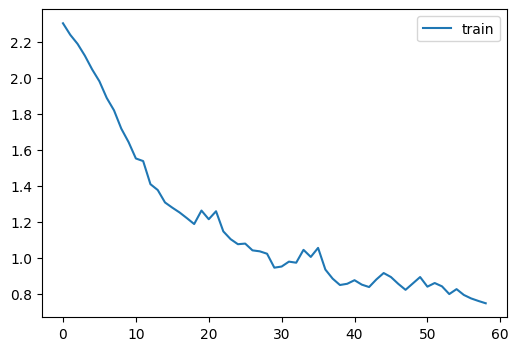

In [16]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(1)

### Momentum Learner
Subclasses from Learner | No need for callback

Achieves momentum mechanism using a simple technique

In [17]:
class MomentumLearner(Learner):
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD, momentum=0.8):
        self.mom = momentum
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step() # it adds
    def zero_grad(self):
        for p in self.model.parameters(): p.grad *= self.mom 

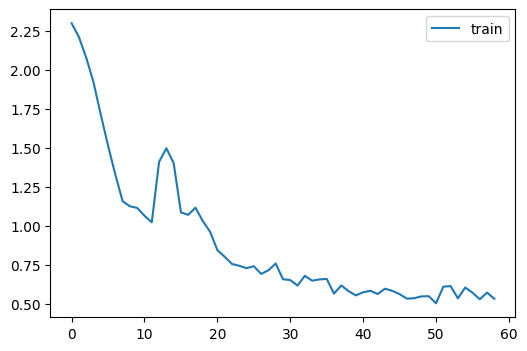

In [25]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(1)

### Learning Rate Finder CB

In [20]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult
    
    def plot(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel('LR')
        plt.ylabel('Loss')

In [21]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

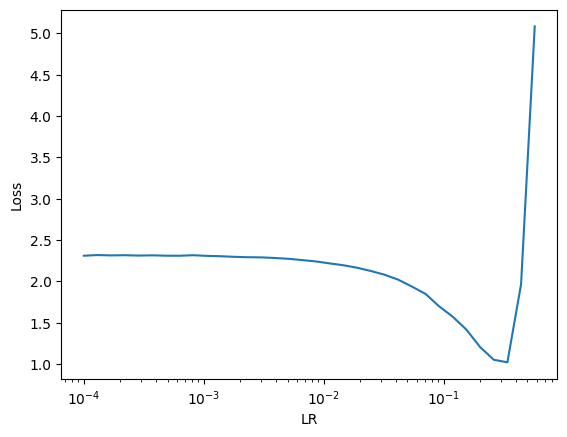

In [22]:
lrfind.plot()

In [23]:
lrfind.min

tensor(1.0233)